In [0]:
# Import the pandas library to read our dataset
import pandas as pd

# Get the train/test split package from sklearn for preparing our dataset to
# train and test the model with
from sklearn.model_selection import train_test_split

# Import the numpy library to work with and manipulate the data
import numpy as np

In [3]:
# import data from google drive
#data = pd.read_csv('train.tsv', sep='\t')
data = pd.read_csv('https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv', sep='\t')

# Check the head of the dataframe
data.head(5)



,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
# check the shape of df
data.shape



(156060, 4)

In [0]:
# Get number of unique sentences
numSentences = data['SentenceId'].max()

In [6]:
# extract full sentences only from the dataset
fullSentences = []
curSentence = 0
for i in range(data.shape[0]):
  if data['SentenceId'][i]> curSentence:
    fullSentences.append((data['Phrase'][i], data['Sentiment'][i]))
    curSentence = curSentence +1

len(fullSentences)


8544

In [7]:
# put data into a df
fullSentDf = pd.DataFrame(fullSentences,
                                columns=['Phrase', 'Sentiment'])

# Check class imbalance in tokenized sentences
data['Sentiment'].value_counts()



2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [8]:
# Check class imbalance in full sentences
fullSentDf['Sentiment'].value_counts()

3    2325
1    2203
2    1659
4    1282
0    1075
Name: Sentiment, dtype: int64

In [9]:
import nltk
import random
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

documents = []
# Use only complete sentences
for i in range(fullSentDf.shape[0]):
  tmpWords = word_tokenize(fullSentDf['Phrase'][i])
  documents.append((tmpWords, fullSentDf['Sentiment'][i]))

random.seed(9001)
random.shuffle(documents)
print(documents[1][0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
['For', 'its', '100', 'minutes', 'running', 'time', ',', 'you', "'ll", 'wait', 'in', 'vain', 'for', 'a', 'movie', 'to', 'happen', '.']


In [10]:
len(documents)

8544

In [11]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
porter = PorterStemmer()
lancaster=LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_en = stopwords.words("english")
punctuations="?:!.,;'\"-()"

#parameters to adjust to see the impact on outcome
remove_stopwords = True
useStemming = True
useLemma = False
removePuncs = True

for l in range(len(documents)):
  label = documents[l][1]
  tmpReview = []
  for w in documents[l][0]:
    newWord = w
    if remove_stopwords and (w in stopwords_en):
      continue
    if removePuncs and (w in punctuations):
      continue
    if useStemming:
      #newWord = porter.stem(newWord)
      newWord = lancaster.stem(newWord)
    if useLemma:
      newWord = wordnet_lemmatizer.lemmatize(newWord)
    tmpReview.append(newWord)
  documents[l] = (' '.join(tmpReview), label)
print(documents[2])

('ian holm conqu frant earthy napoleon', 3)


In [12]:
all_data = pd.DataFrame(documents,
                                columns=['text', 'sentiment'])
# Splits the dataset so 70% is used for training and 30% for testing
x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(all_data['text'], all_data['sentiment'], test_size=0.3)

len(x_train_raw)

5980

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Transform each text into a vector of word counts

vectorizer = TfidfVectorizer(stop_words="english",
                            ngram_range=(1, 2))
train_x = vectorizer.fit_transform(x_train_raw)


train_vectorized = vectorizer.transform(x_train_raw)
train_vectorized= np.array(train_vectorized.toarray())
train_vectorized = train_vectorized.reshape(train_vectorized.shape[0],train_vectorized.shape[1],1)
print(train_vectorized.shape)

test_vectorized = vectorizer.transform(x_test_raw)
test_vectorized= np.array(test_vectorized.toarray())
test_vectorized = test_vectorized.reshape(test_vectorized.shape[0],test_vectorized.shape[1],1)
print(test_vectorized.shape)


(5980, 50526, 1)
(2564, 50526, 1)


In [14]:
from keras.utils import to_categorical
Y_train = to_categorical(y_train_raw)
Y_test = to_categorical(y_test_raw)

Using TensorFlow backend.


In [0]:
from keras import backend as K
def recall_m(y_true,y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0,1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0,1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision= precision_m(y_true, y_pred)
  recall= recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
import numpy as np
from keras import optimizers
np.random.seed(1000)
def CNN_model(fea_matrix, n_class, mode, compiler):
  model = Sequential()
  model.add(Conv1D(filters=16, kernel_size=1, activation='relu',
                  input_shape=(fea_matrix.shape[1],fea_matrix.shape[2])))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Activation('relu'))
  model.add(Dense(n_class))
  
  model.add(Activation('softmax'))
  model.compile(optimizer=compiler,loss='categorical_crossentropy',
                metrics=['acc',f1_m,precision_m,recall_m])
  return model


lr = 1e-3
decay=1e-4
mode="reg"
n_class = 5

adm = optimizers.Adam(lr=lr,decay=decay)
model = CNN_model(train_vectorized,n_class,mode,adm)

In [17]:
#fit the model
x = model.fit(train_vectorized,Y_train,batch_size=64, epochs=10, verbose=1, validation_split=0.3)

#save the model
model.save('1111092_1dconv_reg.h5')

#function call for accuracy f1-score, precision and recall
def metrics(accuracy,f1_score,precision,recall):
  print('CNN model performance')
  print('Accuracy:', np.round(accuracy,2))
  print('Precision: ', np.round(precision,2))
  print("recall:", np.round(recall,2))
  print("f1score:", np.round(f1_score,2))
loss, accuracy, f1_score, precision, recall = model.evaluate(test_vectorized, Y_test, verbose=False)

# get the accuracy,f1_score,presion,recall
metrics(accuracy,f1_score, precision, recall)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4186 samples, validate on 1794 samples
Epoch 1/10





4186/4186 [==============================] - 19s 5ms/step - loss: 1.5771 - acc: 0.2747 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.5480 - val_acc: 0.3551 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/10
4186/4186 [==============================] - 5s 1ms/step - loss: 1.3139 - acc: 0.5886 - f1_m: 0.0146 - precision_m: 0.2255 - recall_m: 0.0076 - val_loss: 1.4912 - val_acc: 0.3506 - val_f1_m: 0.0066 - val_precision_m: 0.1903 - val_recall_m: 0.0033
Epoch 3/10
4186/4186 [==============================] - 5s 1ms/step - loss: 0.6541 - acc: 0.9142 - f1_m: 0.7281 - precision_m: 0.9793 - recall_m: 0.5939 - val_loss: 1.5610 - val_acc: 0.3595 - val_f1_m: 0.2418 - val_precision_m: 0.4142 - val_recall_m: 0.1717
Epoch 4/10
4186/4186 [=============================

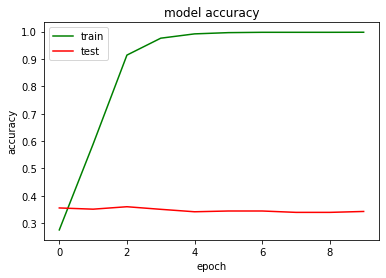

In [18]:
import matplotlib.pyplot as plt
def plothist(hist):
    plt.plot(hist.history['acc'],color='green')
    plt.plot(hist.history['val_acc'],color='red')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
plothist(x)

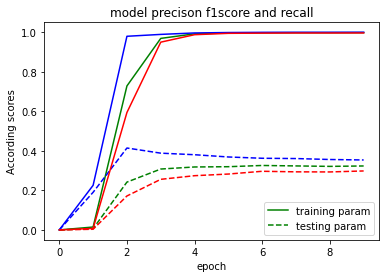

In [19]:
import matplotlib.pyplot as plt
def plothist(hist):
    plt.plot(hist.history['f1_m'],color='green')
    plt.plot(hist.history['val_f1_m'],color='green',linestyle='dashed')
    plt.plot(hist.history['precision_m'],color='blue')
    plt.plot(hist.history['val_precision_m'],color='blue',linestyle='dashed')
    plt.plot(hist.history['recall_m'],color='red')
    plt.plot(hist.history['val_recall_m'],color='red',linestyle='dashed')
    plt.title('model precison f1score and recall')
    plt.legend(['training param','testing param'], loc='lower right')
    plt.ylabel('According scores')
    plt.xlabel('epoch')
    plt.show()
plothist(x)